<a href="https://colab.research.google.com/github/NehaNeha417/loan_prediction/blob/master/Siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import numpy as np

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [24]:
x_train = x_train.reshape((60000, 784))/255.0
x_test = x_test.reshape((10000,784))/255.0

In [27]:
print(x_train.shape)

(60000, 784)


In [28]:
def plot_triplet(triplet):
  plt.figure(figsize=(6,2))
  for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(np.reshape(triplet[i], (28,28)) , cmap='binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()


[18651  9275 41315]


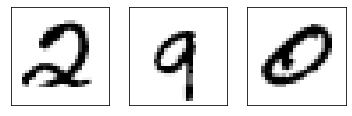

In [33]:
x = np.random.randint(0,60000-1,3)
print(x)
triplet_list = []
for i in x:
  triplet_list.append(x_train[i])
plot_triplet(triplet_list)
   

#plot_triplet([x_train[0],x_train[1],x_train[2]])


In [54]:
def create_batch(batch_size):                            
  x_anchors = np.zeros((batch_size, 784))
  x_positives = np.zeros((batch_size, 784))
  x_negatives = np.zeros((batch_size, 784))

  for i in range(batch_size):
    
    index_for_anc = random.randint(0, 60000-1)
    x_anchor = x_train[index_for_anc]
    y = y_train[index_for_anc]

    index_for_pos = np.squeeze(np.where(y_train == y))
    index_for_neg = np.squeeze(np.where(y_train != y))

    x_positive = x_train[index_for_pos[random.randint(0,len(index_for_pos)-1)]]
    x_negative = x_train[index_for_neg[random.randint(0,len(index_for_neg)-1)]]
    x_anchors[i] = x_anchor
    x_positives[i] = x_positive
    x_negatives[i] = x_negative

  return [x_anchors, x_positives, x_negatives]

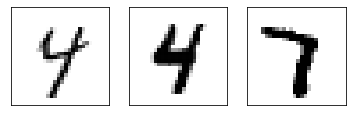

In [57]:
new_triplets = create_batch(1)
plot_triplet(new_triplets)

In [61]:
emb_size = 64
embedding_model = tf.keras.models.Sequential([
                                              tf.keras.layers.Dense(emb_size, activation='relu', input_shape=(784,)),
                                              tf.keras.layers.Dense(64, activation='sigmoid')
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [64]:
example = np.expand_dims(x_train[0], axis=0)
example_embedding = embedding_model.predict(example)[0]
print(example_embedding)

[0.57286626 0.550995   0.4798746  0.4795397  0.46076182 0.4293689
 0.4897737  0.612711   0.4414808  0.57228386 0.45733532 0.50000197
 0.58618855 0.4750168  0.48712826 0.49497086 0.5699493  0.5495995
 0.53018117 0.5528948  0.4210618  0.5111812  0.5601389  0.43741593
 0.5202164  0.5924973  0.48957494 0.47966653 0.5501043  0.56967187
 0.53635305 0.42770362 0.50345737 0.4381371  0.5980284  0.4205498
 0.47922808 0.43043536 0.5645304  0.56986034 0.5235837  0.5347847
 0.42703882 0.44701543 0.5466859  0.3729276  0.5550672  0.41576973
 0.47389838 0.50356907 0.46075663 0.4278267  0.5484039  0.5509758
 0.3353379  0.4948575  0.5058394  0.45782688 0.53513545 0.4085916
 0.5189915  0.58039284 0.4956882  0.4705102 ]


In [75]:
in_anc = tf.keras.layers.Input(shape=(784,))
in_pos = tf.keras.layers.Input(shape=(784,))
in_neg = tf.keras.layers.Input(shape=(784,))

emb_anc = embedding_model(in_anc)
emb_pos = embedding_model(in_pos)
emb_neg = embedding_model(in_neg)

output = tf.keras.layers.concatenate([emb_anc, emb_pos, emb_neg], axis=1)

sia_network = tf.keras.models.Model([in_anc, in_pos ,in_neg], output)
                            
sia_network.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_31[0][0]                   
                                                                 input_32[0][0]        

In [86]:
def triplet_loss(alpha, emb_dim):
  def loss(y_true, y_pred):
    anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:,2*emb_dim:]
    dp = tf.reduce_mean(tf.square(anc-pos), axis=1)
    dn = tf.reduce_mean(tf.square(anc-neg), axis=1)
    return tf.maximum(dp - dn + alpha, 0)
  return loss



In [87]:
def data_generator(alpha, emb_dim):
  while True:
    x = create_batch(batch_size)
    y = np.zeros((batch_size, 3*emb_dim))
    yield x, y

In [88]:
alpha=0.2
emb_dim=64
batch_size = 1024
epochs = 10
steps_per_epoch = 60000/batch_size
sia_network.compile(loss=triplet_loss(alpha, emb_dim), optimizer='adam')

X,Y = x_test[:1000],y_test[:1000]

In [89]:
from pca_plotter import PCAPlotter

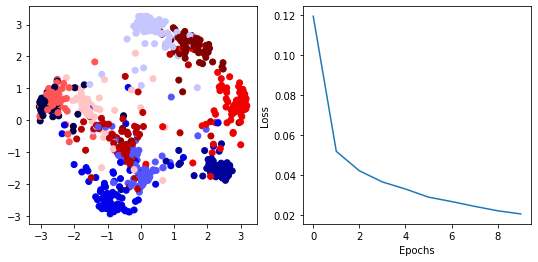

In [90]:
sia_network.fit(
    data_generator(alpha=0.2, emb_dim=emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=False, callbacks=[
                              PCAPlotter(plt, embedding_model, X, Y)
    ]
)